# Réchauffement climatique et flux touristiques en France sur les années 2010
Manon Chevallier, Sara Chikhi, Inza Ouada Soro

# Table des matières
* [1. Import des données](#chapter1)
    * [1.1. Données climatiques](#section_1_1)
    * [1.2. Données touristiques](#section_1_2)
    * [1.3. Jointure](#section_1_3)
* [2. Statistiques descriptives](#chapter2)
    * [2.1. Statistiques sur le climat](#section_2_1)
        * [2.1.1. Variabilité climatique sur le territoire](#sub_section_2_1_1)
        * [2.1.2. Evolution dans le temps](#sub_section_2_1_2)
    * [2.2. Statistiques sur le tourisme](#section_2_1)
        * [2.2.1. Répartition du tourisme sur le territoire](#sub_section_2_2_1)
        * [2.2.2. Evolution des fréquentations touristiques](#sub_section_2_2_2)
    * [2.3. Corrélations](#section_2_1)
* [3. Modélisation](#chapter3)
    * [Présentation du modèle](#section_3_1)
    * [Résultats](#section_3_2)
* [4. Conclusion](#chapter4)


## 1. Import des données <a class="anchor" id="chapter1"></a>

In [1]:
import time
t0 = time.perf_counter()

In [2]:
import os
from IPython.display import clear_output
print(os.getcwd())

/home/onyxia/work/Data Science/Project


Nous utilisons des données climatiques issues de météo france et des données sur les fréquentations touristiques issues d'une enquête mensuelle auprès des établissements touristiques. Ces deux sources de données sont importées à partir d'internet. Les codes permettant d'importer ces données se trouvent dans le dossier src/import_data. 

In [3]:
from src import import_data

Ce dossier comporte deux scripts (api_donnees_climat et api_donnees_tourisme) qui chacun importent les données et les retraitent légèrement pour qu'elles soient cohérentes entre elles. En particulier, il faut qu'elles soient toutes deux au niveau départemental, annuel et mensuel. Chaque ligne de notre table de données correspondra donc à un département x une année x un mois.

### 1.1. Données climatiques <a id="section_1_1"></a>

On importe les données climatiques et on analyse les valeurs manquantes.


In [4]:
import pandas

data_1 = pandas.read_csv("./Data/data_climat.csv")
data_1["DEP"] = data_1["DEP"].astype(str).str.zfill(2)

null_data = data_1[data_1.isnull().any(axis=1)]
print(null_data)

nul = data_1[data_1['TM'].isnull()]
print(nul.DEP.unique())
print(nul.AAAA.unique())
print(nul.MM.unique())

       AAAA  MM         TM         TX          RR        UMM       FFM  \
23     2012  12   3.378261   6.647826  195.681395  88.444444  1.916667   
24     2013   1   1.321739   4.513043  113.476744  90.555556  1.550000   
25     2013   2  -0.122727   3.343478  103.033333  85.625000  1.983333   
26     2013   3   5.427273   9.547826   98.435714  79.125000  1.933333   
27     2013   4  10.018182  14.960870  134.383333  76.000000  2.150000   
...     ...  ..        ...        ...         ...        ...       ...   
13387  2022   8  23.600000  30.050000   34.200000        NaN       NaN   
13388  2022   9  17.800000  22.700000   47.250000        NaN       NaN   
13389  2022  10  16.450000  20.750000   69.850000        NaN       NaN   
13390  2022  11  10.250000  13.250000   48.750000        NaN       NaN   
13391  2022  12   5.650000   7.850000   55.450000        NaN       NaN   

           TXMIN    NBJTX0  NBJTX25  NBJTX30  NBJTX35   NBJNEIG  NBJSOLNG DEP  \
23     -0.495652  2.000000    

### 1.2. Données touristiques <a id="section_1_2"></a>

On importe les données touristiques et on analyse les valeurs manquantes.

In [5]:
data_2 = pandas.read_csv("./Data/data_tourisme.csv")
data_2["DEP"] = data_2["DEP"].astype(str).str.zfill(2)

null_data = data_2[data_2.isnull().any(axis=1)]
print(null_data)


Empty DataFrame
Columns: [AAAA, MM, DEP, DEP_NOM, TOUR_RESID, OBS_VALUE_CORR]
Index: []


### 1.3. Jointure <a id="section_1_2"></a>

On utilise une fonction de jointure écrite dans src/package_project/preparation_data.
On vérifie de nouveau qu'il n'existe pas de valeurs manquantes sur nos indicateurs d'intérêt ; cela peut arriver si tous les départements ou toutes les années ne sont pas présents dans les deux tables par exemple.

In [6]:
from src import package_project as pp

df = pp.preparation_data.merge_data(data_1, data_2)

nul_data1 = df[df['TX'].isnull()]
nul_data2 = df[df['OBS_VALUE_CORR'].isnull()]

print("Valeurs manquantes de température dans les données finales :")
print(nul_data1.DEP.unique())
print(nul_data1.AAAA.unique())
print(nul_data1.MM.unique())
df.to_csv("base.csv")

print("Valeurs manquantes d'arrivées dans les données finales :")
print(nul_data2.DEP.unique())
print(nul_data2.AAAA.unique())
print(nul_data2.MM.unique())


Valeurs manquantes de température dans les données finales :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Valeurs manquantes d'arrivées dans les données finales :
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '2A' '2B']
[2020 2021 2011 2012 2013 2014 2015 2016 2017 2018 2019 2022]
[ 1  2  3  4  5  6 11 12  7  8  9 10]


On observe que les arrivées touristiques sont manquantes pour la période du covid. On va donc exclure les années concernées pour ne pas biaiser les résultats.

In [7]:
import pandas

df.to_csv("base.csv")


## 2. Statistiques descriptives <a id="chapter_2"></a>

La plupart des statistiques descriptives seront présentées sous forme de carte.



In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

### 2.1. Statistiques sur le climat <a id="section_2_1"></a>


#### 2.1.1. Variabilité climatique sur le territoire <a id="section_2_1_1"></a>

La France est un pays avec une grande variabilité climatique sur le territoire

In [9]:
# parametres
mois_ete = [6, 7, 8, 9]
mois_hiver = [1,2,3,12]
toutes_annees = [i for i in range(2011, 2023)]


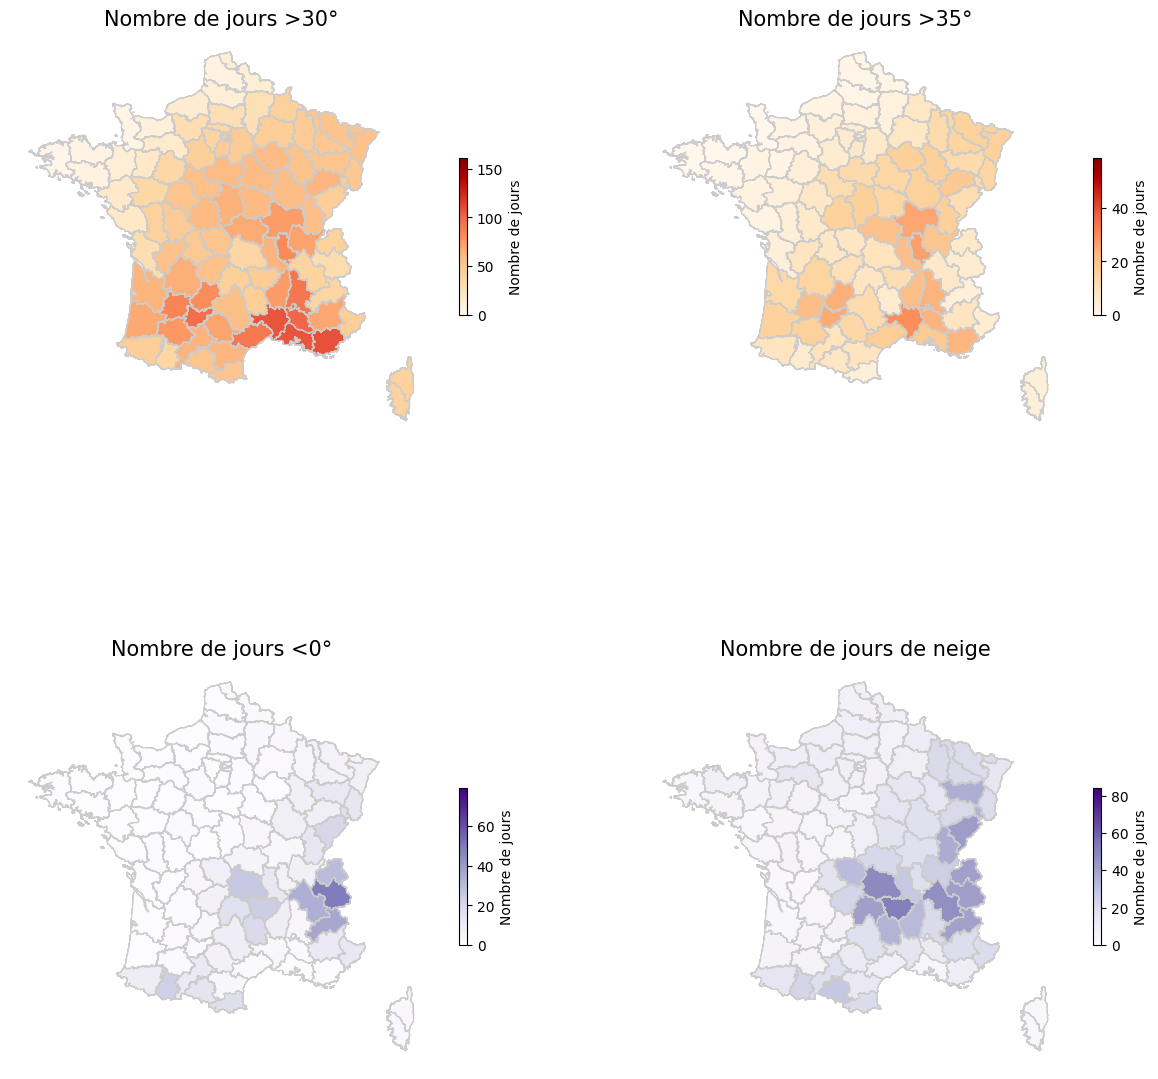

In [10]:
# TEMPS APPROXIMATIF : 40sec
from src.package_project import cartes, indicateurs_climat
# construction des cartes 

fig, ax = plt.subplots(2,2, figsize=(15, 15))

# été : nombre de jours à plus de 30 degrés et 35 degrés  
cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_ete, "NBJTX30")),
            toutes_annees,
            mois_ete,
            "NBJTX30",
            "Nombre de jours >30°",
            ax[0,0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_ete, "NBJTX35")),
            toutes_annees,
            mois_ete,
            "NBJTX35",
            "Nombre de jours >35°",
            ax[0,1],
            evolution = False)

# # hiver : nombre de jours à moins de 0° ou de neige  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_hiver, "NBJTX0")),
            toutes_annees,
            mois_hiver,
            "NBJTX0",
            "Nombre de jours <0°",
            ax[1,0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_hiver, "NBJNEIG")),
            toutes_annees,
            mois_hiver,
            "NBJNEIG",
            "Nombre de jours de neige",
            ax[1,1],
            evolution = False)



#### 2.1.2. Evolution dans le temps <a id="section_2_1_2"></a>

On s'intéresse maintenant à l'évolution du climat dans le temps. 

In [11]:
from src.package_project.Carte_dyn import gif
from IPython.display import display, HTML

gif("hiver")
gif("été")

html = """
<div style="display:flex;">
    <img src="cart_pour_les hiver.gif" style="width:500px;"/>
    <img src="cart_pour_les été.gif" style="width:500px;"/>
</div>
"""

display(HTML(html))

In [12]:
t1 = time.perf_counter()
print(f"Temps d'affichage : {t1 - t0:.3f}s")

Temps d'affichage : 59.271s


Ces cartes dynamiques nous permettent de constater que s'il y a une tendance au réchauffement entre 2011 et 2022 (en particulier l'été), il y a une certaine variabilité selon les années. 

Intéressons nous aux évènements extrèmes (forte chaleur ou températures basses). Pour lisser les variations annuelles, on s'intéresse à l'évolution de la moyenne du nombre annuel de jours extremes, entre avant 2015 (inclus) et après 2015 (non inclus.)

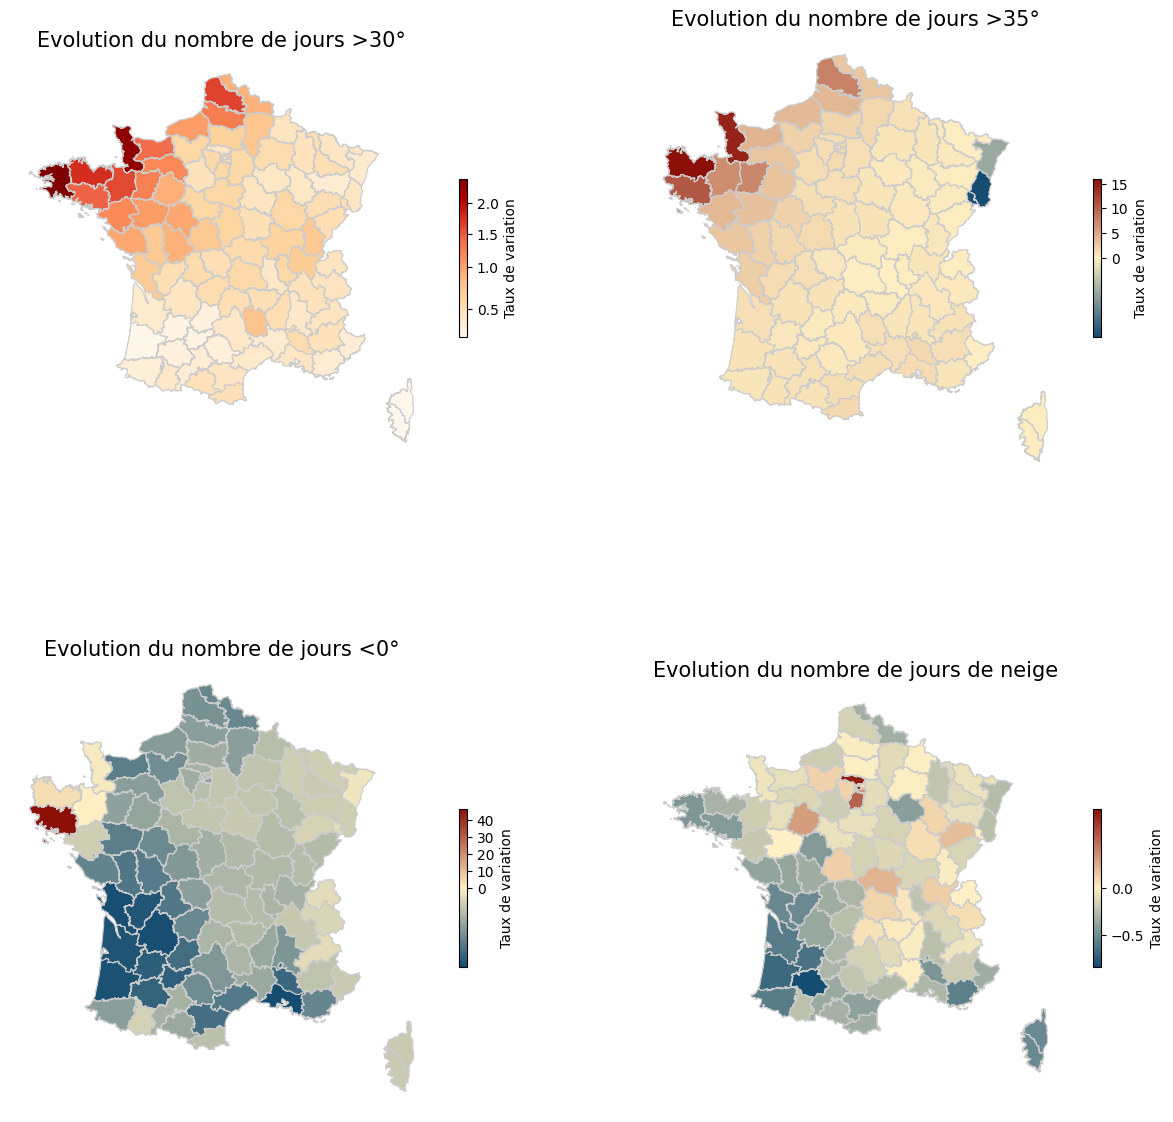

In [13]:
# évolution des évènements extremes 

fig, ax = plt.subplots(2,2, figsize=(15, 15))

# été : nombre de jours à plus de 30 degrés et 35 degrés  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "été", "NBJTX30")),
            toutes_annees,
            mois_ete,
            "NBJTX30",
            "Evolution du nombre de jours >30°",
            ax[0,0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "été", "NBJTX35")),
            toutes_annees,
            mois_ete,
            "NBJTX35",
            "Evolution du nombre de jours >35°",
            ax[0,1],
            evolution = True)

# # hiver : nombre de jours à moins de 0° ou de neige  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "hiver", "NBJTX0")),
            toutes_annees,
            mois_hiver,
            "NBJTX0",
            "Evolution du nombre de jours <0°",
            ax[1,0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "hiver", "NBJNEIG")),
            toutes_annees,
            mois_hiver,
            "NBJNEIG",
            "Evolution du nombre de jours de neige",
            ax[1,1],
            evolution = True)

### 2.2. Statistiques sur le tourisme <a id="section_2_2"></a>

#### 2.2.1. Répartition du tourisme sur le territoire <a id="section_2_2_1"></a>

Intéressons-nous à la répartition du tourisme sur le territoire français. 

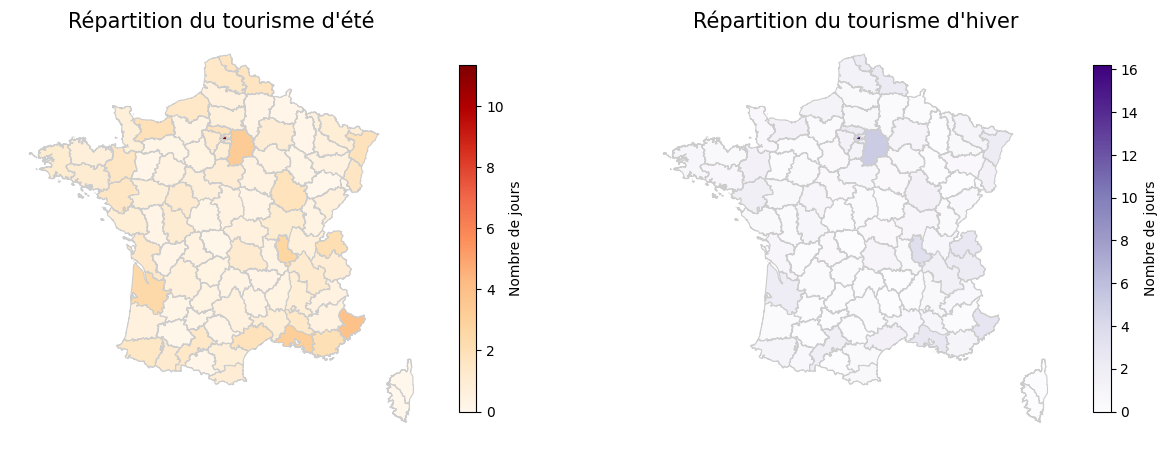

In [14]:
from src.package_project import indicateurs_tourisme

mois_hiver = [1,2,3, 12]
fig, ax = plt.subplots(1,2, figsize=(15, 15))

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df, toutes_annees, mois_ete, ["DEP"])),
            toutes_annees,
            mois_ete,
            "part_tourisme",
            "Répartition du tourisme d'été",
            ax[0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df, toutes_annees, mois_hiver, ["DEP"])),
            toutes_annees,
            mois_hiver,
            "part_tourisme",
            "Répartition du tourisme d'hiver",
            ax[1],
            evolution = False)



Paris absorbe une grande part du tourisme d'été ou d'hiver. Pour avoir une meilleure visibilité du tourisme non-parisien, on exclut Paris. 

In [15]:
# A FAIRE

Nous observons que le tourisme est plus fort sur le littoral en été. 

La répartition reste néanmoins relativement proche. Une hypothèse pouvant l'expliquer est le fait qu'une partie du tourisme serait en réalité des déplacements non-touristiques (fréquentation d'un hôtel pour raison professionnelle par exemple). Dans ce cas, la répartition touristique est fortement influencée par l'activité économique des départements.

Si cette hypothèse est vérifiée, il est probable que les données donnent une corrélation assez faible entre fréquentation touristique et évolution du climat, a minima sur les départements non côtiers ou montagneux.

#### 2.2.2. Evolution des fréquentations touristiques <a id="section_2_2_2"></a>


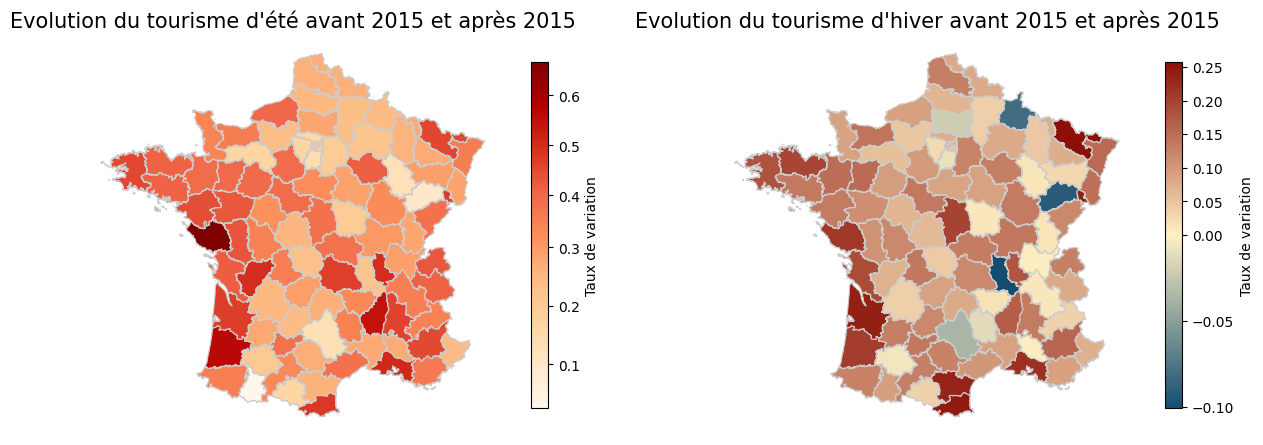

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15, 15))

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.evol_arrivees(df, mois_ete)),
            toutes_annees,
            mois_ete,
            "evol_2015",
            "Evolution du tourisme d'été avant 2015 et après 2015",
            ax[0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.evol_arrivees(df, mois_hiver)),
            toutes_annees,
            mois_hiver,
            "evol_2015",
            "Evolution du tourisme d'hiver avant 2015 et après 2015",
            ax[1],
            evolution = True)

### 2.3. Corrélations <a id="section_2_3"></a>

Nous allons calculer le coefficient de corrélation global avant de s'intéresser aux coefficients de corrélation par département et par saison

In [17]:
col_arrivees = "OBS_VALUE_CORR"
col_temp = "TX"

base_clean = df.dropna(subset=[col_arrivees, col_temp]).copy()

corr_global = base_clean[col_arrivees].corr(base_clean[col_temp], method="pearson")
print("Corrélation globale arrivées / TX :", corr_global)

Corrélation globale arrivées / TX : 0.11760185712297337


Nous calculons le coefficient de corrélation linéaire de Pearson entre le nombre d'arrivée touristiques (OBS_VALUE_CORR) et la température maximale moyenne mensuelle (TX) sur l'ensemble des départements et des périodes. 
Le coefficient de corrélation globale est 0.15, ce qui traduit un lien positif mais faible entre les deux variables : les hausses de températures s'accompagnent en moyenne d'une légère hausse des arrivées, sans que le climat ne soit le déterminant principal des flux. 

Nous qualifions de forte une corrélation lorsque |r|≥0.5 et nous affichons uniquement les départements présentant une corrélation fortement positive (r≥0.5) ou fortement négative (r≤−0,5).

In [18]:
# Par Département
corr_par_dep = (
    base_clean
    .groupby("DEP")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

dep_corr_forte_pos = corr_par_dep[corr_par_dep["corr_arrivees_TX"] >= 0.75]
liste_dep_forte_positive = corr_par_dep.loc[corr_par_dep["corr_arrivees_TX"] >= 0.75, "DEP"].tolist()
dep_corr_forte_neg = corr_par_dep[corr_par_dep["corr_arrivees_TX"] <= -0.5]

print("Départements à corrélation fortement POSITIVE :")
print(dep_corr_forte_pos)
print(liste_dep_forte_positive)

print("\nDépartements à corrélation fortement NÉGATIVE :")
print(dep_corr_forte_neg)

Départements à corrélation fortement POSITIVE :
  DEP  corr_arrivees_TX
5  06          0.781861
['06']

Départements à corrélation fortement NÉGATIVE :
Empty DataFrame
Columns: [DEP, corr_arrivees_TX]
Index: []


In [19]:
# Par Saison
corr_par_saison = (
    base_clean
    .groupby("saison")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

print("\nCorrélation arrivées / TX par saison :")
print(corr_par_saison)

# Par Période
corr_par_periode = (
    base_clean
    .groupby("periode")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

print("\nCorrélation arrivées / TX par période :")
print(corr_par_periode)



Corrélation arrivées / TX par saison :
  saison  corr_arrivees_TX
0  Other          0.069817
1  hiver          0.020797
2    été          0.052333

Corrélation arrivées / TX par période :
      periode  corr_arrivees_TX
0  apres_2015          0.111447
1  avant_2015          0.125432


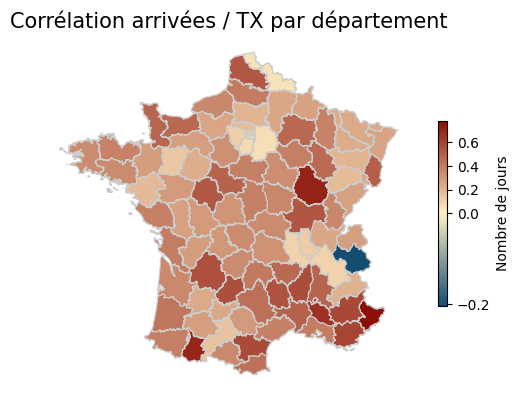

In [20]:
corr_dep = corr_par_dep.copy()
corr_dep["DEP"] = corr_dep["DEP"].astype(str).str.zfill(2)

annees = toutes_annees
mois=mois_ete
fig, ax = plt.subplots(figsize=(6, 8))

cartes.mise_en_forme_carte(
    cartes.donnee_carte(corr_dep),
    annees=toutes_annees,
    mois=mois_ete,
    indicateur= "corr_arrivees_TX", 
    titre_carte= "Corrélation arrivées / TX par département", 
    plotting=ax, 
    evolution=False
)

## 3. Modélisation <a id="chapter_3"></a>
### 3.1. Présentation du modèle <a id="section_3_1"></a>
### Cadre théorique : désaisonnalisation
Pourquoi désaisonnaliser avant les tests de stationnarité ?
Les tests de racine unitaire (ADF, PP, KPSS) reposent sur des hypothèses asymptotiques qui sont violées en présence de :
saisonnalité déterministe non traitée, ruptures périodiques régulières (mensuelles ici). Une saisonnalité non corrigée peut conduire à : une fausse non-stationnarité, une surestimation de l’ordre d’intégration,
des conclusions erronées sur la cointégration.

Approche retenue : saisonnalité déterministe
Nous utilisons une approche classique et valide économétriquement :

Yt = µ + 𝛿1 * D1 + ... + 𝛿12 * D11 + ε où ε~BB(0,sd), 𝐷𝑚 : sont des dummies mensuelles,
Décision :
si au moins un coefficient saisonnier est significatif alors saisonnalité présente
sinon alors pas de correction nécessaire

### Cadre théorique : test de Dickey-Fuller augmenté (ADF)
Problématique de la stationnarité
En économétrie des séries temporelles, une série non stationnaire pose trois problèmes majeurs :
risque de régression fallacieuse, lois asymptotiques non standards, tests de significativité invalides
Une série est stationnaire si : sa moyenne est constante, sa variance est finie et constante, sa structure d’autocorrélation est stable dans le temps

H₀ : la série possède une racine unitaire (non stationnaire) VS H₁ : la série est stationnaire

Décision :
si p-value < α → rejet de H₀ → série stationnaire
sinon on calcule la serie differncier(Yt - Yt-1) puis on refait le test.

l'ordre d'integration est le nombre de foi que l'on à du differencier la serie pour que celle -ci devienne stattionnaire

### Cadre théorique :modèle ARDL 

Le modèle ARDL (AutoRegressive Distributed Lag) est adapté lorsque : Les variables sont intégrées d’ordre différent (I(0) et I(1)), et que l'on souhaite distinguer effets de court terme et relation de long terme.

Forme générale :

Yt = µ + 𝛿1 * D1 + ... + 𝛿12 * D11 + a1 * Yt-1 + ... + ap * Yt-p + b1 * X't + ... + bq * X't-p + ε ou ε~BB(0,sd)

Yt: flux touristique à la periode t

𝑋t : variables climatiques à la periode t

𝛽 : effet du climat sur le flux touristique

### Modèle de prediction :XGBOOST

XGBoost est un algorithme de gradient boosting sur arbres de décision qui construit un modèle prédictif comme une somme séquentielle d’arbres faibles, chaque nouvel arbre corrigeant les erreurs des précédents par descente de gradient.
Sa spécificité réside dans une fonction objectif régularisée et l’utilisation d’une approximation de Taylor d’ordre 2, ce qui lui confère une forte performance prédictive, au prix d’une interprétabilité limitée et sans vocation causale.


### 3.2. Présentation du modèle <a id="section_3_2"></a>


DÉPARTEMENT : Allier

#1) Préparation des données
DÉPARTEMENT 03
2011 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2012 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2013 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2014 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2015 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2016 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2017 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2018 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2019 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2020 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2021 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2022 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

NOTE MÉTHODOLOGIQUE
- Données postérieures à 2020 exclues (crise sanitaire)
- Mois manquants interpolés par méthode temporelle
- Flux touristique transformé en logarithme

#2) An

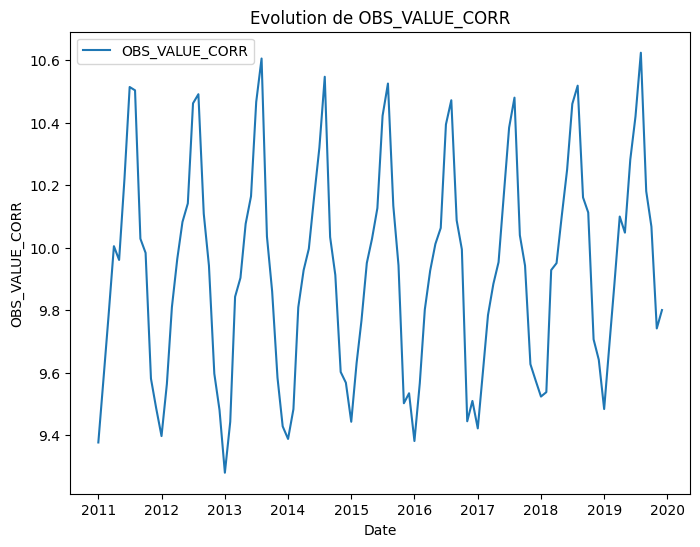

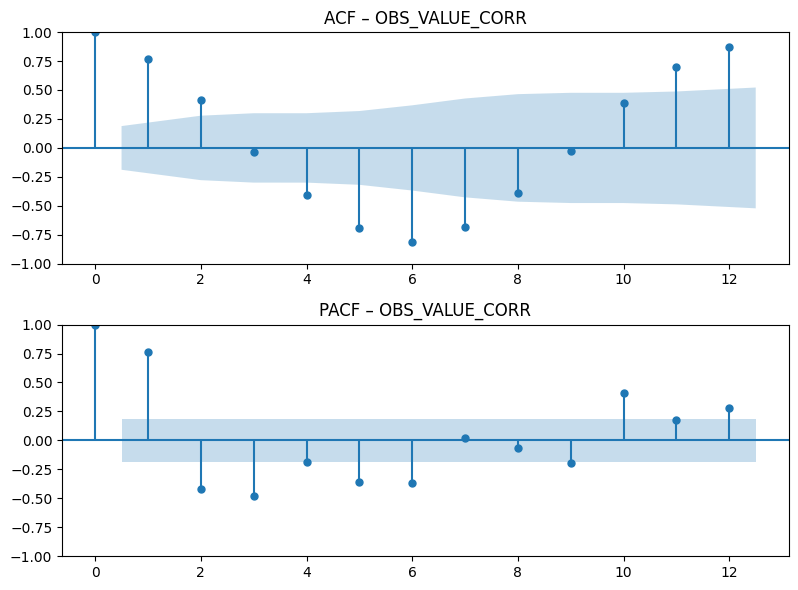

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:         OBS_VALUE_CORR   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     257.0
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           4.76e-66
Time:                        09:53:29   Log-Likelihood:                 138.54
No. Observations:                 108   AIC:                            -253.1
Df Residuals:                      96   BIC:                            -220.9
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

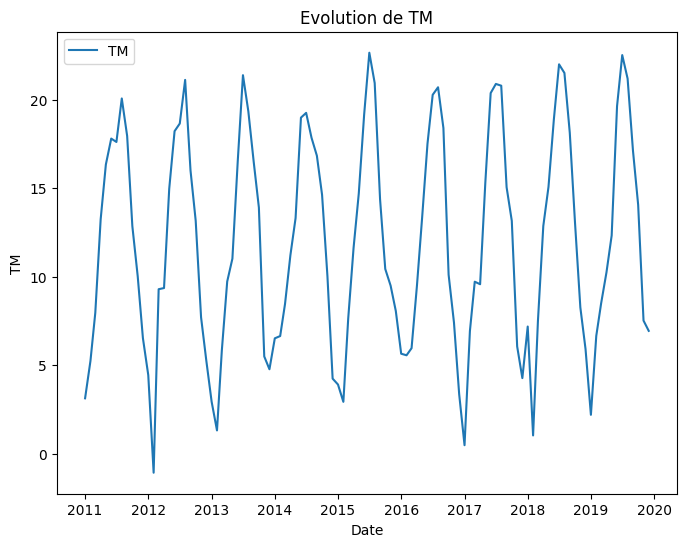

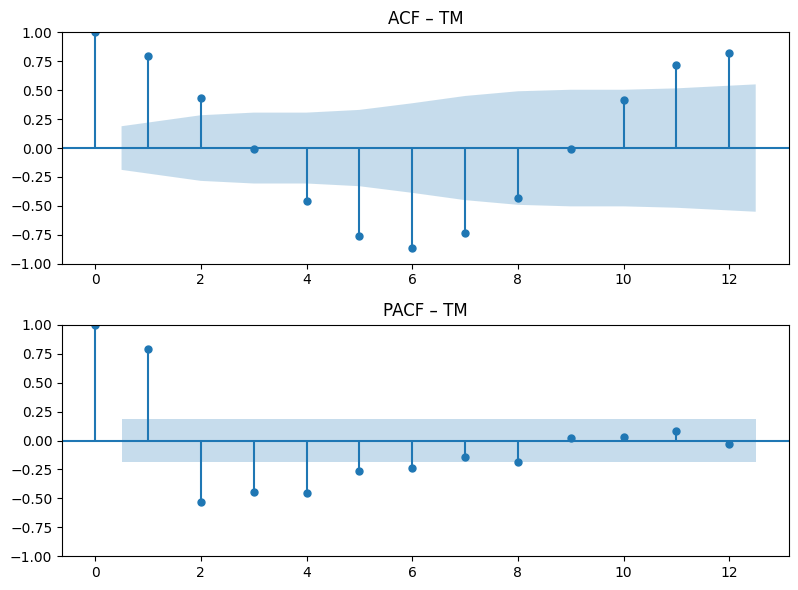

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     136.6
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           1.58e-53
Time:                        09:53:29   Log-Likelihood:                -204.85
No. Observations:                 108   AIC:                             433.7
Df Residuals:                      96   BIC:                             465.9
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

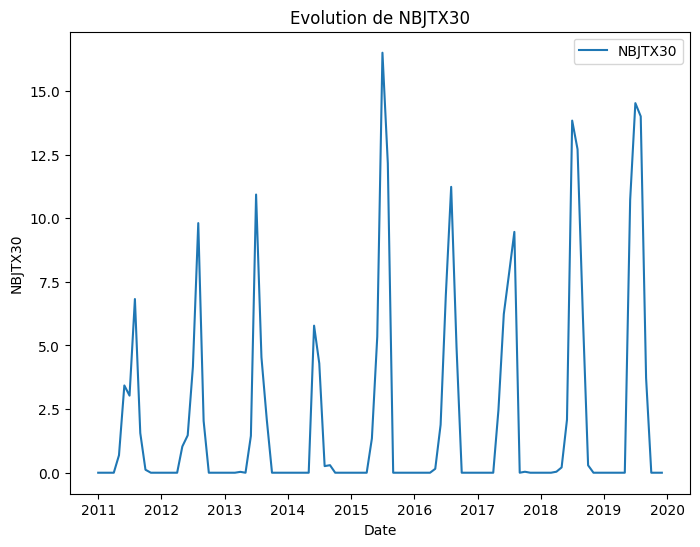

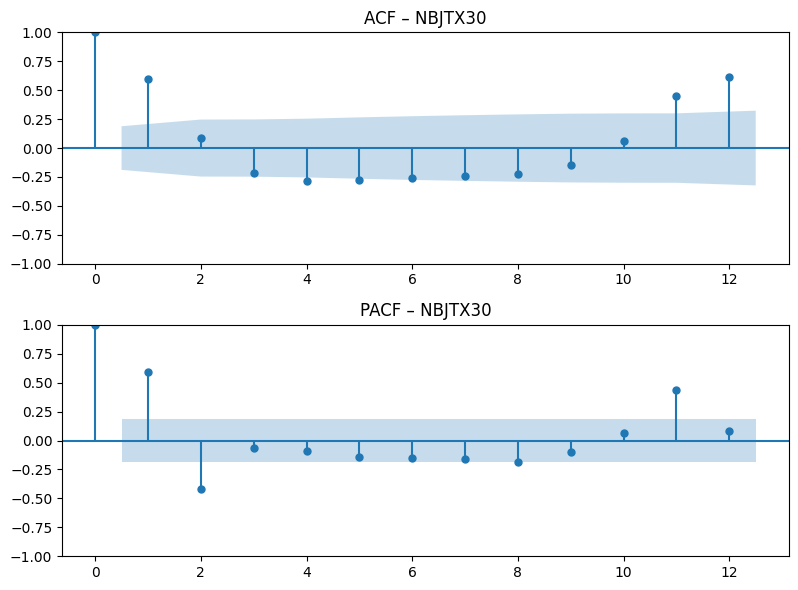

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                NBJTX30   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     14.92
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           4.85e-13
Time:                        09:53:30   Log-Likelihood:                -233.39
No. Observations:                 108   AIC:                             490.8
Df Residuals:                      96   BIC:                             523.0
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

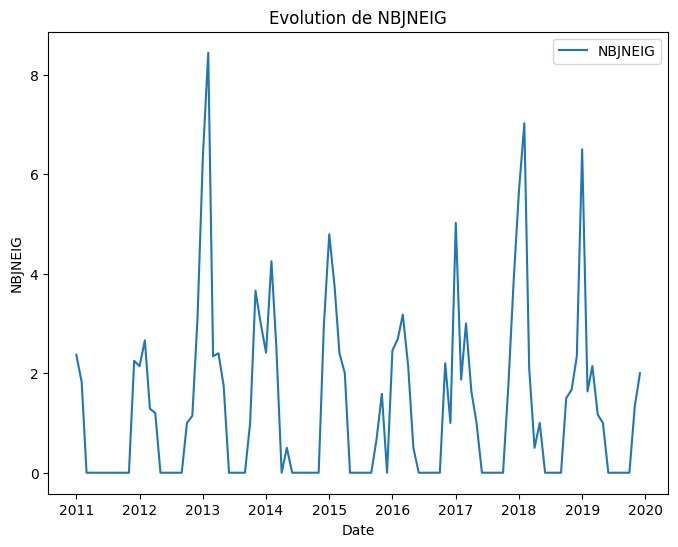

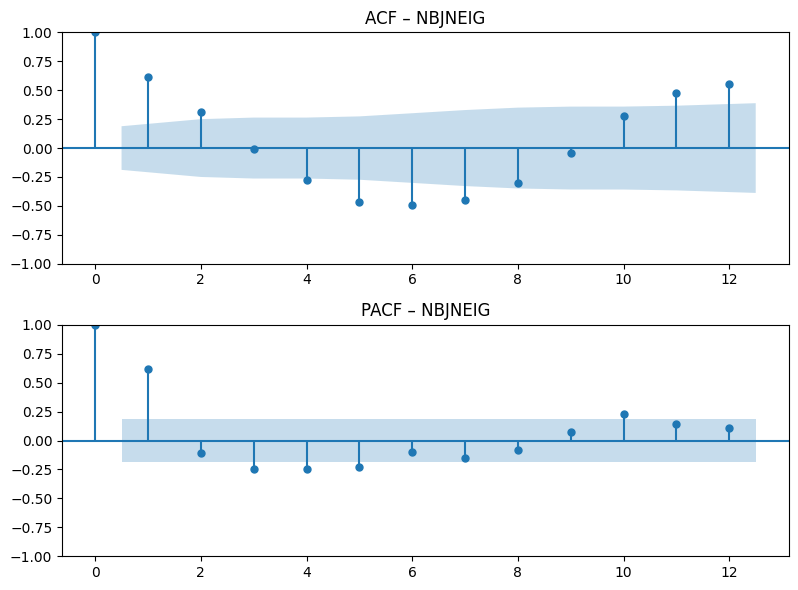

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                NBJNEIG   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     24.32
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           5.26e-20
Time:                        09:53:30   Log-Likelihood:                -156.38
No. Observations:                 108   AIC:                             336.8
Df Residuals:                      96   BIC:                             368.9
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

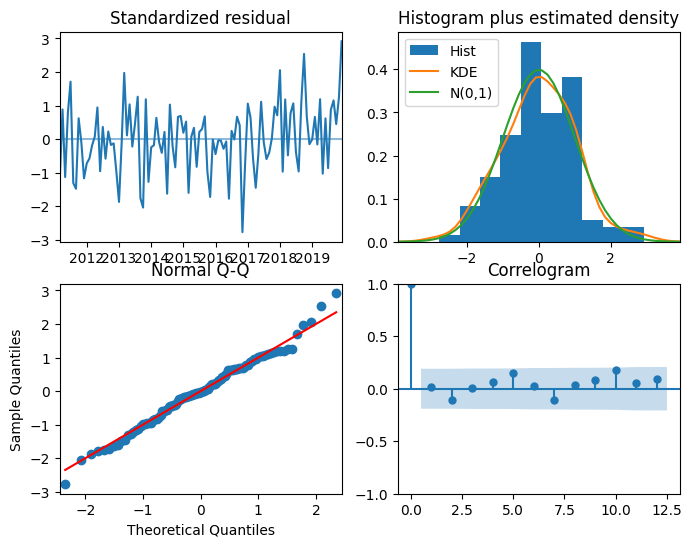

Rélation de long terme Analyse
                                UECM Model Results                                
Dep. Variable:           D.OBS_VALUE_CORR   No. Observations:                  108
Model:             Seas. UECM(2, 1, 1, 1)   Log Likelihood                 157.095
Method:                   Conditional MLE   S.D. of innovations              9.941
Date:                    Fri, 26 Dec 2025   AIC                           -278.190
Time:                            09:53:35   BIC                           -230.248
Sample:                        03-01-2011   HQIC                          -258.759
                             - 12-01-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.6215      1.089      2.407      0.018       0.457       4.786
s(2,12)                 0.1924      0.034

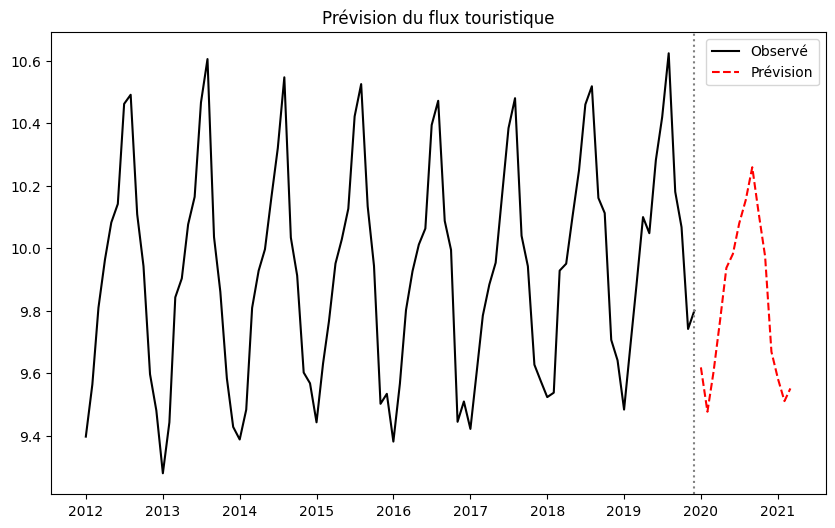

(3,
 'Allier',
 {2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2012: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2013: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2014: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2015: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2017: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2018: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2019: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2020: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2021: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2022: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
 np.int64(0),
 ('Série corrigée de la saisonnalité déterministe', 1),
 ('Série corrigée de la saisonnalité déterministe', 0),
 ('Série corrigée de la saisonnalité déterministe', 0),
 ('Série corrigée de la saisonnalité déterministe', 0),
 'Il existe une relation de long terme entre le climat et les flux touristiques. Le changement climatique influence structurellement l’attractivité touristiqu

In [21]:
from src.package_project.Test import Test, Resultat
Test(3)

In [22]:
t0 = time.perf_counter()
dataset = Resultat(95)
clear_output(wait=True)
t1 = time.perf_counter()
print(f"Temps d'execution : {t1 - t0:.3f}s")

Temps d'execution : 647.935s


In [23]:
import pandas as pd
dataset.to_csv("dataset.csv")
dataset.head()

,departement,nom_dep,donne_pres,qualite,OBS_VALUE_CORR,TM,NBJTX30,NBJNEIG,conclusion,code
0,1.0,Ain,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon
1,2.0,Aisne,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Les résultats sont ambigus. La relation de lon...,incertain
2,3.0,Allier,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon
3,4.0,Alpes-de-Haute-Provence,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Les variables climatiques ne présentent pas d’...,mauvais
4,5.0,Hautes-Alpes,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon


In [24]:
dataset.code.value_counts()

code
mauvais      58
bon          30
incertain     3
Name: count, dtype: int64

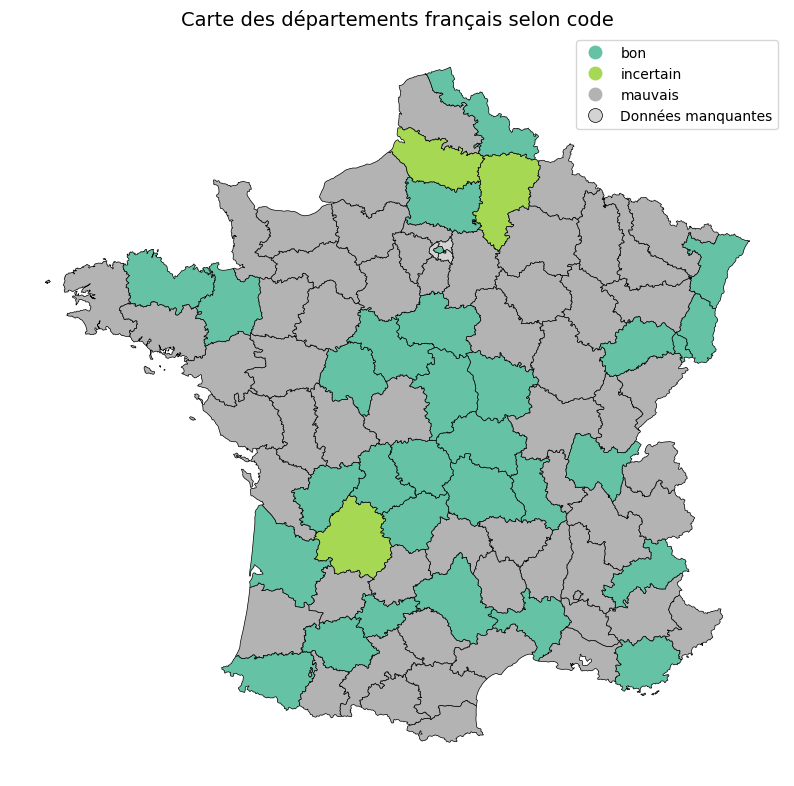

In [27]:
dataset = pd.read_csv("dataset.csv")
from src.package_project.Carte_dyn import carte_departements
carte_departements(dataset)